# ***Pneumonia Detection: Using Chest X-ray Images***

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zipfile import ZipFile
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Dataset 

def getkaggledata():
  from google.colab import files
  files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  # Kaggle API command for the dataset (Change the API Command here)
  !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
  # os.rename("face-mask-12k-images-dataset.zip","facemask.zip")

# Get the dataset from Kaggle
getkaggledata()

Saving kaggle.json to kaggle.json
100% 2.29G/2.29G [00:31<00:00, 27.3MB/s]
100% 2.29G/2.29G [00:31<00:00, 77.5MB/s]


In [3]:
def extractfromzip(filename):
  with ZipFile(filename,'r') as zip:
    zip.extractall()
    print("Dataset created!")

extractfromzip("chest-xray-pneumonia.zip")

Dataset created!


In [4]:
base_dir = "/content/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# ***Data augmentation: Using ImageDataGenerator***

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   zoom_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(160,160),
                                                  class_mode='categorical',
                                                  batch_size=64)

validation_dataset = test_datagen.flow_from_directory(validation_dir,
                                                  target_size=(160,160),
                                                  class_mode='categorical',
                                                  batch_size=64)

test_dataset = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(160,160),
                                                  class_mode='categorical',
                                                  batch_size=64)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# 0 -- Normal scan  //// 1 -- Pneumoniatic scan
class_names = ['Normal', 'Pneumonia']

# Selects some images from the train_dataset (Iterator object)
images,labels = next(iter(train_dataset))

# Plots the images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    if (labels[i]==1.0):plt.xlabel(class_names[1])
    elif (labels[i]==0.0): plt.xlabel(class_names[0])
    

plt.show()

# ***Transfer Learning: VGG19***

In [29]:
# Load model
base_model = keras.applications.VGG19(include_top=False,
                                      weights='imagenet',
                                      input_shape=(160,160,3))

base_model.trainable= False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## **Adding a top to the base model**

In [30]:
model = keras.Sequential([
          base_model,
          keras.layers.Flatten(),
          keras.layers.Dense(64, activation='relu'),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                819264    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 20,843,778
Trainable params: 819,394
Non-trainable params: 20,024,384
_________________________________________________________________


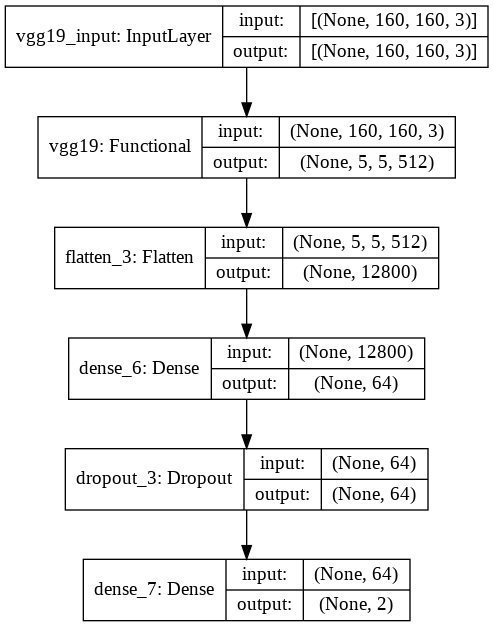

In [31]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

keras.utils.plot_model(model, show_shapes=True)

In [32]:
history = model.fit(train_dataset,
          batch_size=64,
          epochs=5,
          validation_data=validation_dataset)

Epoch 1/5
82/82 [==============================] - 117s 955ms/step - loss: 0.6743 - accuracy: 0.7828 - val_loss: 0.6316 - val_accuracy: 0.7500
Epoch 2/5
82/82 [==============================] - 75s 909ms/step - loss: 0.2204 - accuracy: 0.9147 - val_loss: 0.4014 - val_accuracy: 0.8750
Epoch 3/5
82/82 [==============================] - 75s 908ms/step - loss: 0.2136 - accuracy: 0.9223 - val_loss: 0.4793 - val_accuracy: 0.8125
Epoch 4/5
82/82 [==============================] - 74s 903ms/step - loss: 0.2018 - accuracy: 0.9301 - val_loss: 0.4213 - val_accuracy: 0.8750
Epoch 5/5
82/82 [==============================] - 74s 901ms/step - loss: 0.1945 - accuracy: 0.9288 - val_loss: 0.4715 - val_accuracy: 0.7500


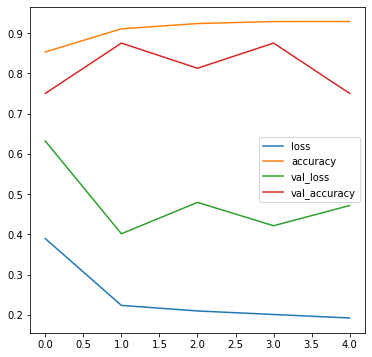

In [33]:
df = pd.DataFrame(history.history)
df.plot(figsize=(6,6))
plt.legend()

## Fine tuning of model

In [35]:
len(base_model.layers)

22

In [36]:
# Unfreeze all the layers
base_model.trainable = True

# Freeze the bottom layers
for layer in base_model.layers[:18]:
  layer.trainable = False

In [37]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                819264    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 20,843,778
Trainable params: 7,898,818
Non-trainable params: 12,944,960
_________________________________________________________________


## Fine Tuning: Compile & run model again

In [38]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

total_epochs = 15

In [39]:
es_callback = keras.callbacks.EarlyStopping(patience=3, verbose=1, restore_best_weights=True)

history_fine = model.fit(train_dataset,
                         batch_size=64,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=es_callback)

Epoch 5/15
82/82 [==============================] - 76s 920ms/step - loss: 0.2063 - accuracy: 0.9274 - val_loss: 0.4048 - val_accuracy: 0.6875
Epoch 6/15
82/82 [==============================] - 75s 915ms/step - loss: 0.1492 - accuracy: 0.9524 - val_loss: 0.6203 - val_accuracy: 0.6875
Epoch 7/15
82/82 [==============================] - 75s 913ms/step - loss: 0.1243 - accuracy: 0.9623 - val_loss: 0.2017 - val_accuracy: 0.9375
Epoch 8/15
82/82 [==============================] - 74s 898ms/step - loss: 0.1124 - accuracy: 0.9651 - val_loss: 0.2182 - val_accuracy: 0.9375
Epoch 9/15
82/82 [==============================] - 74s 896ms/step - loss: 0.1253 - accuracy: 0.9564 - val_loss: 0.1365 - val_accuracy: 0.9375
Epoch 10/15
82/82 [==============================] - 74s 903ms/step - loss: 0.1034 - accuracy: 0.9603 - val_loss: 0.0984 - val_accuracy: 0.9375
Epoch 11/15
82/82 [==============================] - 75s 913ms/step - loss: 0.1042 - accuracy: 0.9646 - val_loss: 0.1184 - val_accuracy: 1.00

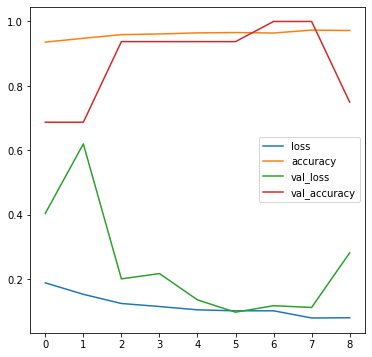

In [40]:
df1 = pd.DataFrame(history_fine.history)
df1.plot(figsize=(6,6))
plt.legend()

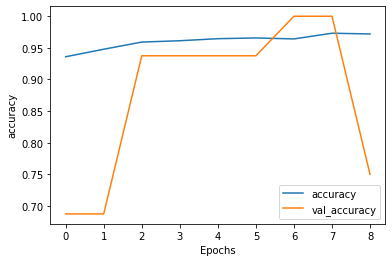

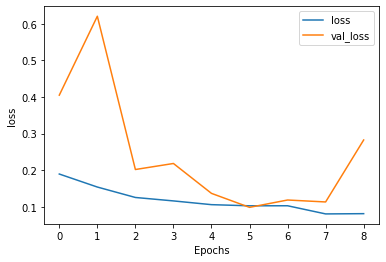

In [42]:
import matplotlib.pyplot as plt

def plot_graph(history, word):
  plt.plot(history.history[word])
  plt.plot(history.history['val_'+word])
  plt.xlabel('Epochs')
  plt.ylabel(word)
  plt.legend([word, 'val_'+ word])
  plt.show()

plot_graph(history_fine, 'accuracy')
plot_graph(history_fine, 'loss')

## Model Evaluation

In [50]:
# Evaluation of model

loss, accuracy = model.evaluate(test_dataset)
print("\n\nLoss: ", loss)
print("Accuracy: {:.2f}".format(accuracy*100),"\n")

10/10 [==============================] - 5s 524ms/step - loss: 0.3595 - accuracy: 0.9199


Loss:  0.35952943563461304
Accuracy: 91.99 



## Testing the model

Saving p.jpg to p.jpg


Final prediction: 
The image is most likely Pneumonia with the accuracy of 73.10585379600525


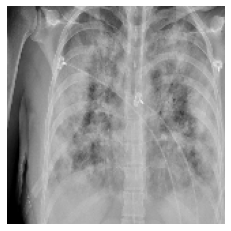

In [67]:
# Import the required libraries

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()


for fn in uploaded.keys():

  # print("\n\nThe key is: "+ fn+"\n\n")
  # Predicting images
  # Full path for the image
  path = '/content/' + fn
  # Load the image into the img variable
  img = image.load_img(path, target_size =(160,160))
  x = image.img_to_array(img) # Convert the image into array
  x = np.expand_dims(x, axis=0) # Expand the images as if they were many images

  images = np.vstack([x]) # Important
  classes = model.predict(images, batch_size=10)  # Gives the predictions for each classes like: eg:  [classes[0]: ([ 3.729408   -0.32879975  0.60124546 -3.0891216   0.56141305])]
  score = tf.nn.softmax(classes[0]) #Put the predictions into a softmax layer to get a [score: (tf.tensor)]


  # np.argmax(): Indicies of the max of the predictions
  # Finally to get the name of the predicted class we write the next line i.e the class_names[index(found above)]
  name = class_names[np.argmax(score)]
  accuracy = 100 * np.max(score) # Accuracy percentage

  plt.imshow(img)
  plt.axis("off")
  print("\n\nFinal prediction: ")
  print("The image is most likely "+ name +" with the accuracy of " + str(accuracy) )

## Saving the model

In [68]:
# Saving model

model.save("Pneumonia_detection.h5")

## Testing using Saved Model

Saving normalxray.jpg to normalxray (4).jpg


Final prediction: 
The image is most likely Normal with the accuracy of 73.10585379600525


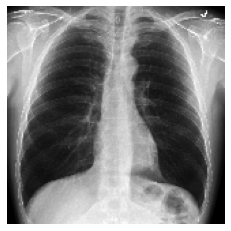

In [70]:
# Import the required libraries

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()


for fn in uploaded.keys():

  # print("\n\nThe key is: "+ fn+"\n\n")
  # Predicting images
  # Full path for the image
  path = '/content/' + fn
  # Load the image into the img variable
  img = image.load_img(path, target_size =(160,160))
  x = image.img_to_array(img) # Convert the image into array
  x = np.expand_dims(x, axis=0) # Expand the images as if they were many images

  # Importing model
  model1 = keras.models.load_model("Pneumonia_detection.h5")

  images = np.vstack([x]) # Important
  classes = model1.predict(images, batch_size=10)  # Gives the predictions for each classes like: eg:  [classes[0]: ([ 3.729408   -0.32879975  0.60124546 -3.0891216   0.56141305])]
  score = tf.nn.softmax(classes[0]) #Put the predictions into a softmax layer to get a [score: (tf.tensor)]


  # np.argmax(): Indicies of the max of the predictions
  # Finally to get the name of the predicted class we write the next line i.e the class_names[index(found above)]
  name = class_names[np.argmax(score)]
  accuracy = 100 * np.max(score) # Accuracy percentage

  plt.imshow(img)
  plt.axis("off")
  print("\n\nFinal prediction: ")
  print("The image is most likely "+ name +" with the accuracy of " + str(accuracy) )